In [144]:
import os
import pandas as pd
import numpy as np
from scipy import stats

from statsmodels.stats.proportion import proportions_ztest
import matplotlib.pyplot as plt


In [145]:

df = pd.read_csv('cookie_cats.csv')


print(df.head(10))
print(' ')

print('shape is : ', df.shape)

   userid  version  sum_gamerounds  retention_1  retention_7
0     116  gate_30               3        False        False
1     337  gate_30              38         True        False
2     377  gate_40             165         True        False
3     483  gate_40               1        False        False
4     488  gate_40             179         True         True
5     540  gate_40             187         True         True
6    1066  gate_30               0        False        False
7    1444  gate_40               2        False        False
8    1574  gate_40             108         True         True
9    1587  gate_40             153         True        False
 
shape is :  (90189, 5)


In [146]:
#normalization
df['version'] = df['version'].astype(str).str.strip().str.lower()

In [147]:
df[['retention_1', 'retention_7']] = df[['retention_1', 'retention_7']].astype(bool)

print(df['retention_1'].value_counts())
print(' ')
print(df['retention_7'].value_counts())
print(' ')
print(df['version'].value_counts())
print(' ')





retention_1
False    50036
True     40153
Name: count, dtype: int64
 
retention_7
False    73408
True     16781
Name: count, dtype: int64
 
version
gate_40    45489
gate_30    44700
Name: count, dtype: int64
 


In [148]:
#grouping
def group_stats(df, group_col, outcome_col, group_label):
    
    g = df[df[group_col] == group_label]
    n = len(g)
    if n == 0:
        raise ValueError(f"No observations for group '{group_label}'.")
    x = int(g[outcome_col].sum())
    p = x / n
    return n, x, p


In [149]:
# 2porportions test z-test
def run_two_proportion_ztest(x1, n1, x2, n2, alternative='two-sided'):
    
    count = np.array([x1, x2])
    nobs  = np.array([n1, n2])
    zstat, pval = proportions_ztest(count, nobs, alternative=alternative)
    return float(zstat), float(pval)


In [150]:
# CI
def diff_confidence_interval(p1, p2, n1, n2, alpha=0.05):
    """
    Returns (diff, se, ci_lower, ci_upper)
    where diff = p1 - p2
    """
    diff = p1 - p2
    se = np.sqrt(p1*(1-p1)/n1 + p2*(1-p2)/n2)
    z_crit = stats.norm.ppf(1 - alpha/2)
    ci_lower = diff - z_crit * se
    ci_upper = diff + z_crit * se
    return float(diff), float(se), float(ci_lower), float(ci_upper)


In [151]:
#dictionaery return cell
def two_proportion_test(df, group_col, outcome_col, group_a='gate_30', group_b='gate_40', alpha=0.05):
    n1, x1, p1 = group_stats(df, group_col, outcome_col, group_a)
    n2, x2, p2 = group_stats(df, group_col, outcome_col, group_b)

    zstat, pval = run_two_proportion_ztest(x1, n1, x2, n2, alternative='two-sided')
    diff, se, ci_lower, ci_upper = diff_confidence_interval(p1, p2, n1, n2, alpha=alpha)

    return {
        'outcome': outcome_col,
        'group_a': group_a, 'n1': n1, 'x1': x1, 'p1': p1,
        'group_b': group_b, 'n2': n2, 'x2': x2, 'p2': p2,
        'zstat': zstat, 'pval': pval,
        'diff_p1_p2': diff, 'se_diff': se,
        'ci_lower': ci_lower, 'ci_upper': ci_upper
    }



In [152]:
#call both retentions and return summary
res_r1 = two_proportion_test(df, 'version', 'retention_1', group_a='gate_30', group_b='gate_40')
res_r7 = two_proportion_test(df, 'version', 'retention_7', group_a='gate_30', group_b='gate_40')

summary = pd.DataFrame([res_r1, res_r7])

summary


,outcome,group_a,n1,x1,p1,group_b,n2,x2,p2,zstat,pval,diff_p1_p2,se_diff,ci_lower,ci_upper
0,retention_1,gate_30,44700,20034,0.448188,gate_40,45489,20119,0.442283,1.784086,0.074410,0.005905,0.003310,-0.000582,0.012392
1,retention_7,gate_30,44700,8502,0.190201,gate_40,45489,8279,0.182000,3.164359,0.001554,0.008201,0.002592,0.003121,0.013282


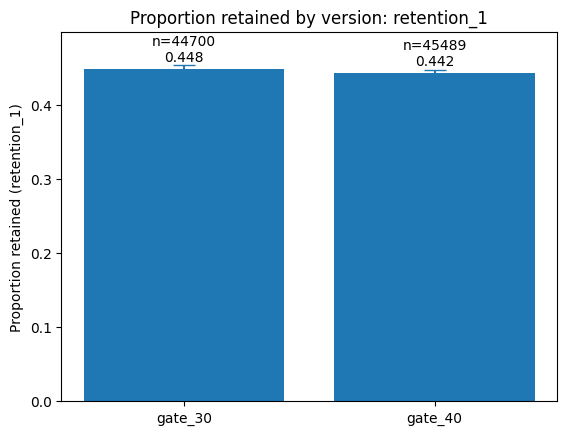

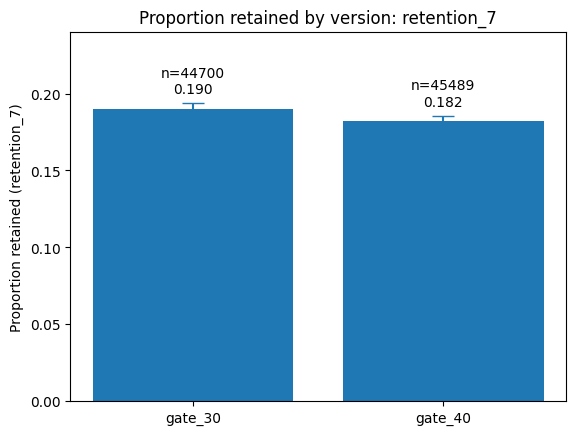

In [153]:
#visualisation
def plot_prop_with_ci(df, outcome_col, group_col='version', groups=['gate_30','gate_40']):
    stats_list = []
    for g in groups:
        d = df[df[group_col] == g]
        n = len(d)
        x = d[outcome_col].sum()
        p = x / n
        se = np.sqrt(p*(1-p)/n)
        z = stats.norm.ppf(0.975)
        ci_low = p - z*se
        ci_hi  = p + z*se
        stats_list.append({'group': g, 'p': p, 'ci_low': ci_low, 'ci_hi': ci_hi, 'n': n})
    stats_df = pd.DataFrame(stats_list)

    fig, ax = plt.subplots()
    ax.bar(stats_df['group'], stats_df['p'])
    ax.errorbar(stats_df['group'], stats_df['p'], yerr=[stats_df['p'] - stats_df['ci_low'], stats_df['ci_hi'] - stats_df['p']],
                fmt='none', capsize=8)
    ax.set_ylim(0, min(1, stats_df['p'].max() + 0.05))
    ax.set_ylabel(f'Proportion retained ({outcome_col})')
    ax.set_title(f'Proportion retained by version: {outcome_col}')
    for i, r in stats_df.iterrows():
        ax.text(i, r['p'] + 0.01, f"n={r['n']}\n{r['p']:.3f}", ha='center')
    plt.show()

plot_prop_with_ci(df, 'retention_1')
plot_prop_with_ci(df, 'retention_7')


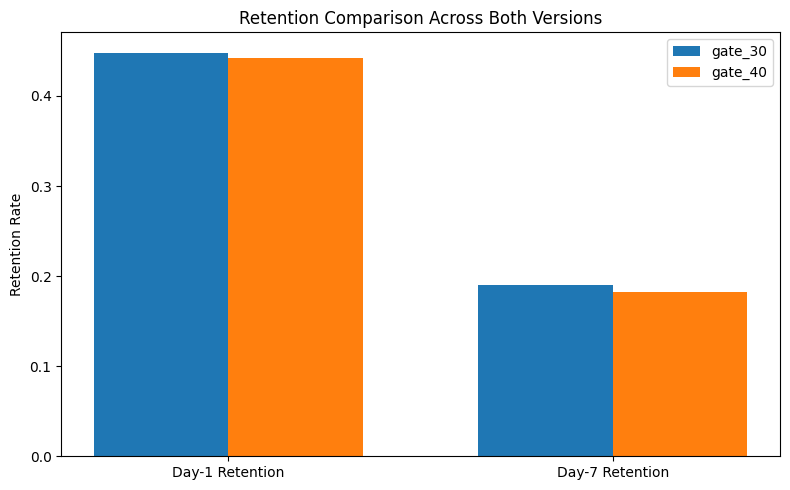

In [154]:
plot_data = []
for metric in metrics:
    for g in groups:
        subset = df[df['version'] == g]
        p = subset[metric].mean()
        plot_data.append([metric, g, p])
plot_df = pd.DataFrame(plot_data, columns=['metric','group','proportion'])

pivot = plot_df.pivot(index='metric', columns='group', values='proportion').reindex(metrics)

# plotting
x = np.arange(len(metrics))               
width = 0.35                              #bar width
colors = {'gate_30': 'tab:blue', 'gate_40': 'tab:orange'}

fig, ax = plt.subplots(figsize=(8,5))

bars = []
for j, g in enumerate(groups):
    offset = (j - (len(groups)-1)/2) * width   
    bars.append(
        ax.bar(x + offset, pivot[g].values, width=width, label=g, color=colors[g])
    )

# cosmetics
ax.set_xticks(x)
ax.set_xticklabels(['Day-1 Retention','Day-7 Retention'])
ax.set_ylabel('Retention Rate')
ax.set_title('Retention Comparison Across Both Versions')

handles = [b[0] for b in bars]  
ax.legend(handles=handles, labels=groups)

plt.tight_layout()
plt.show()

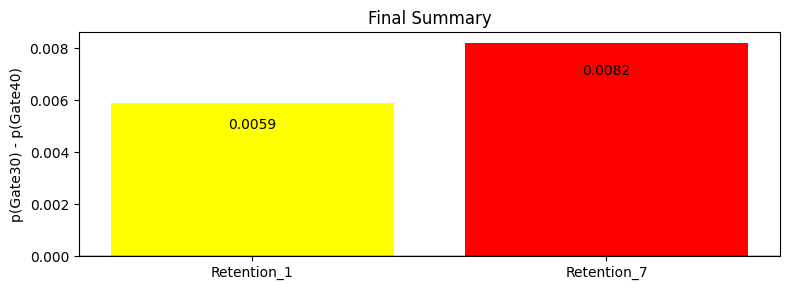


FINAL SUMMARY TABLE:



,Metric,Gate_30,Gate_40,Difference (p30-p40),P-Value
0,Retention_1,0.448188,0.442283,0.005905,0.074410
1,Retention_7,0.190201,0.182000,0.008201,0.001554


In [155]:
metric_colors = {'Retention_1': 'yellow', 'Retention_7': 'red'}

colors = final_summary['Metric'].map(metric_colors).tolist()

fig, ax = plt.subplots(figsize=(8,3))
bars = ax.bar(final_summary['Metric'], 
              final_summary['Difference (p30-p40)'],
              color=colors)

ax.axhline(0, color='black', linewidth=1)
ax.set_ylabel("p(Gate30) - p(Gate40)")
ax.set_title("Final Summary")

#bar customization
for bar in bars:
    h = bar.get_height()
    offset = 0.10 * abs(h)
    y = h - offset if h > 0 else h + offset
    ax.text(bar.get_x()+bar.get_width()/2, y,
            f"{h:.4f}", ha='center', va='top' if h>0 else 'bottom')

plt.tight_layout()
plt.show()

print("\nFINAL SUMMARY TABLE:\n")
display(final_summary)


In [156]:


def interpret_ab_test(df, alpha=0.05, effect_size_threshold=0.01):
    """
    Given a DataFrame with columns containing:
      - metric name (column containing 'metric' or 'Metric')
      - a difference column (p30 - p40)
      - a p-value column
    returns a copy with two new columns:
      - 'reject_H0' (bool)
      - 'conclusion' (str): plain-language conclusion for each metric.

    effect_size_threshold is a proportion (e.g. 0.01 == 1%) used to flag small effects.
    """
    df = df.copy()

    # Find relevant columns (flexible to capitalization / small name differences)
    pcol = next((c for c in df.columns if 'p-value' in c.lower() or 'pvalue' in c.lower() or c.lower() == 'p'), None)
    diffcol = next((c for c in df.columns if 'difference' in c.lower() or 'diff' in c.lower()), None)
    metriccol = next((c for c in df.columns if 'metric' in c.lower()), None)

    if pcol is None or diffcol is None or metriccol is None:
        raise ValueError("Could not detect required columns. Expect columns for Metric, Difference and P-Value.")

    # Ensure numeric types
    df[pcol] = pd.to_numeric(df[pcol], errors='coerce')
    df[diffcol] = pd.to_numeric(df[diffcol], errors='coerce')

    def dir_text(d):
        if pd.isna(d):
            return "unknown direction"
        if d > 0:
            return "Gate_30 higher"
        elif d < 0:
            return "Gate_40 higher"
        else:
            return "no difference"

    rejects = []
    conclusions = []
    for _, row in df.iterrows():
        metric = row[metriccol]
        p = row[pcol]
        diff = row[diffcol]

        if pd.isna(p):
            rejects.append(False)
            conclusions.append(f"{metric}: p-value missing → cannot draw a conclusion.")
            continue

        reject = bool(p < alpha)
        rejects.append(reject)

        direction = dir_text(diff)
        diff_pct = f"{diff:+.4%}" if not pd.isna(diff) else "N/A"

        if reject:
            concl = (f"Reject H0 for {metric} (p = {p:.4f}). Observed difference (p30 - p40) = {diff_pct} → {direction}.")
            if not pd.isna(diff) and abs(diff) < effect_size_threshold:
                concl += f" Note: effect size is small ({diff:.4%}) — check practical significance."
        else:
            concl = (f"Fail to reject H0 for {metric} (p = {p:.4f}). Observed difference (p30 - p40) = {diff_pct} → {direction}.")
        conclusions.append(concl)

    df['reject_H0'] = rejects
    df['conclusion'] = conclusions
    return df

# -----------------------
# Example usage with your table:
data = {
    'Metric': ['Retention_1', 'Retention_7'],
    'Gate_30': [0.448188, 0.190201],
    'Gate_40': [0.442283, 0.182000],
    'Difference (p30-p40)': [0.005905, 0.008201],
    'P-Value': [0.074410, 0.001554]
}
final_summary = pd.DataFrame(data)

interpreted = interpret_ab_test(final_summary, alpha=0.05, effect_size_threshold=0.01)
# Print conclusions
for txt in interpreted['conclusion']:
    print(' ')
    print(txt)
    print (' ')

# Show the DataFrame with added columns
interpreted


 
Fail to reject H0 for Retention_1 (p = 0.0744). Observed difference (p30 - p40) = +0.5905% → Gate_30 higher.
 
 
Reject H0 for Retention_7 (p = 0.0016). Observed difference (p30 - p40) = +0.8201% → Gate_30 higher. Note: effect size is small (0.8201%) — check practical significance.
 


,Metric,Gate_30,Gate_40,Difference (p30-p40),P-Value,reject_H0,conclusion
0,Retention_1,0.448188,0.442283,0.005905,0.074410,False,Fail to reject H0 for Retention_1 (p = 0.0744)...
1,Retention_7,0.190201,0.182000,0.008201,0.001554,True,Reject H0 for Retention_7 (p = 0.0016). Observ...
